<a href="https://colab.research.google.com/github/thisishasan/data_mining_and_machine_learning/blob/main/data_mining_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Domain: Environment

Application Scenario: CO2 emissions

Data Type: Multivariate Time series

Dataset Link: https://carbonmonitor.org/

Objective: Anomaly detection, structural breaks, clustering of countries


https://arxiv.org/pdf/2405.02340?

https://arxiv.org/html/2412.20582v1#bib

https://otexts.com/fpp3/expsmooth.html

https://www.datacamp.com/tutorial/isolation-forest?utm_cid=19589720821&utm_aid=157156374951&utm_campaign=230119_1-ps-other~dsa-tofu~all_2-b2c_3-emea_4-prc_5-na_6-na_7-le_8-pdsh-go_9-nb-e_10-na_11-na&utm_loc=9181205-&utm_mtd=-c&utm_kw=&utm_source=google&utm_medium=paid_search&utm_content=ps-other~emea-en~dsa~tofu~tutorial~machine-learning&gad_source=1&gad_campaignid=19589720821&gbraid=0AAAAADQ9WsFDNrfj9SWS_lZJVZn12VLLM&gclid=Cj0KCQiA18DMBhDeARIsABtYwT3VaFaR6q42NpXkwOae_Ltztj4SVzG9ZwsgtBCrAeBTYKrhESrWvg8aAp8mEALw_wcB

In [394]:
!wget -O dataset.csv 'https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global'

--2026-02-16 01:09:14--  https://datas.carbonmonitor.org/API/downloadFullDataset.php?source=carbon_global
Resolving datas.carbonmonitor.org (datas.carbonmonitor.org)... 167.99.128.168
Connecting to datas.carbonmonitor.org (datas.carbonmonitor.org)|167.99.128.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/x-csv]
Saving to: ‘dataset.csv’

dataset.csv             [             <=>    ]  29.69M  6.93MB/s    in 4.3s    

2026-02-16 01:09:21 (6.93 MB/s) - ‘dataset.csv’ saved [31132365]



In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [396]:
!pip -q install tslearn

In [397]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

In [398]:
df = pd.read_csv('dataset.csv')
df.head()

,country,date,sector,value,Unnamed: 4
0,Austria,01/01/2019,Domestic Aviation,0.000066,NaN
1,Austria,01/01/2019,Ground Transport,0.075841,NaN
2,Austria,01/01/2019,Industry,0.022979,NaN
3,Austria,01/01/2019,International Aviation,0.005686,NaN
4,Austria,01/01/2019,Power,0.010620,NaN


In [399]:
df = df.drop(columns=['Unnamed: 4'])
display(df.head())

,country,date,sector,value
0,Austria,01/01/2019,Domestic Aviation,0.000066
1,Austria,01/01/2019,Ground Transport,0.075841
2,Austria,01/01/2019,Industry,0.022979
3,Austria,01/01/2019,International Aviation,0.005686
4,Austria,01/01/2019,Power,0.010620


In [400]:
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Number of duplicate rows in country_domestic_aviation_df: {len(duplicate_rows)}")
if not duplicate_rows.empty:
    display(duplicate_rows.head())

Number of duplicate rows in country_domestic_aviation_df: 0


In [401]:
print("\nCheck Null values:")
display(df.isnull().sum())


Check Null values:


,0
country,0
date,0
sector,0
value,0


In [402]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.head()

,country,date,sector,value
0,Austria,2019-01-01,Domestic Aviation,0.000066
1,Austria,2019-01-01,Ground Transport,0.075841
2,Austria,2019-01-01,Industry,0.022979
3,Austria,2019-01-01,International Aviation,0.005686
4,Austria,2019-01-01,Power,0.010620


In [403]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591084 entries, 0 to 591083
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   country  591084 non-null  object        
 1   date     591084 non-null  datetime64[ns]
 2   sector   591084 non-null  object        
 3   value    591084 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 18.0+ MB


In [404]:
df = df[~df["country"].isin(["WORLD", "EU27", "ROW"])].copy()

In [405]:
unique_countries = df['country'].unique()
print("Unique Countries:")
for country in unique_countries:
    print(f"- {country}")

Unique Countries:
- Austria
- Belgium
- Brazil
- Bulgaria
- China
- Croatia
- Cyprus
- Czech Republic
- Denmark
- Estonia
- Finland
- France
- Germany
- Greece
- Hungary
- India
- Ireland
- Italy
- Japan
- Latvia
- Lithuania
- Luxembourg
- Malta
- Netherlands
- Norway
- Poland
- Portugal
- Romania
- Russian Federation
- Slovakia
- Slovenia
- Spain
- Sweden
- Switzerland
- United Kingdom
- United States


In [406]:
unique_sectors = df['sector'].unique()
print("\nUnique Sectors:")
for sector in unique_sectors:
    print(f"- {sector}")


Unique Sectors:
- Domestic Aviation
- Ground Transport
- Industry
- International Aviation
- Power
- Residential


In [407]:
italy_df = df[df['country'] == 'Italy']
display(italy_df.head())

,country,date,sector,value
108,Italy,2019-01-01,Domestic Aviation,0.004446
109,Italy,2019-01-01,Ground Transport,0.299442
110,Italy,2019-01-01,Industry,0.106282
111,Italy,2019-01-01,International Aviation,0.022354
112,Italy,2019-01-01,Power,0.106628


In [408]:
italy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15156 entries, 108 to 590963
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   country  15156 non-null  object        
 1   date     15156 non-null  datetime64[ns]
 2   sector   15156 non-null  object        
 3   value    15156 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 592.0+ KB


In [409]:
italy_sector_counts = italy_df.groupby('sector').size().reset_index(name='count')
display(italy_sector_counts)

,sector,count
0,Domestic Aviation,2526
1,Ground Transport,2526
2,Industry,2526
3,International Aviation,2526
4,Power,2526
5,Residential,2526


In [410]:
duplicate_italy_rows = italy_df[italy_df.duplicated(keep=False)]
print(f"Number of duplicate rows in Italy data: {len(duplicate_italy_rows)}")

Number of duplicate rows in Italy data: 0


In [411]:
italy_domestic_aviation_df = italy_df[italy_df['sector'] == 'Domestic Aviation']
display(italy_domestic_aviation_df.head())

,country,date,sector,value
108,Italy,2019-01-01,Domestic Aviation,0.004446
342,Italy,2019-01-02,Domestic Aviation,0.006196
576,Italy,2019-01-03,Domestic Aviation,0.006216
810,Italy,2019-01-04,Domestic Aviation,0.006328
1044,Italy,2019-01-05,Domestic Aviation,0.005640


In [412]:
italy_domestic_aviation_df = italy_domestic_aviation_df.sort_values(by='date')
italy_domestic_aviation_df['delta'] = italy_domestic_aviation_df['date'] - italy_domestic_aviation_df['date'].shift(1)

display(italy_domestic_aviation_df[['date', 'delta']].head())
display(italy_domestic_aviation_df['delta'].sum(), italy_domestic_aviation_df['delta'].count())

,date,delta
108,2019-01-01,NaT
342,2019-01-02,1 days
576,2019-01-03,1 days
810,2019-01-04,1 days
1044,2019-01-05,1 days


Timedelta('2525 days 00:00:00')

np.int64(2525)

In [413]:
italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['delta'], errors='ignore')
display(italy_domestic_aviation_df.head())

,country,date,sector,value
108,Italy,2019-01-01,Domestic Aviation,0.004446
342,Italy,2019-01-02,Domestic Aviation,0.006196
576,Italy,2019-01-03,Domestic Aviation,0.006216
810,Italy,2019-01-04,Domestic Aviation,0.006328
1044,Italy,2019-01-05,Domestic Aviation,0.005640


In [414]:
italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['country'], errors='ignore')
display(italy_domestic_aviation_df.head())

,date,sector,value
108,2019-01-01,Domestic Aviation,0.004446
342,2019-01-02,Domestic Aviation,0.006196
576,2019-01-03,Domestic Aviation,0.006216
810,2019-01-04,Domestic Aviation,0.006328
1044,2019-01-05,Domestic Aviation,0.005640


In [415]:
print("Null values in Domestic Aviation DataFrame:")
display(italy_domestic_aviation_df.isnull().sum())

Null values in Domestic Aviation DataFrame:


,0
date,0
sector,0
value,0


In [416]:
italy_domestic_aviation_df = italy_domestic_aviation_df.drop(columns=['sector'], errors='ignore')
display(italy_domestic_aviation_df.head())

,date,value
108,2019-01-01,0.004446
342,2019-01-02,0.006196
576,2019-01-03,0.006216
810,2019-01-04,0.006328
1044,2019-01-05,0.005640


In [417]:
italy_domestic_aviation_monthy_df = italy_domestic_aviation_df[['date','value']].resample('ME', on='date').mean().reset_index(drop=False)
display(italy_domestic_aviation_monthy_df.head())

,date,value
0,2019-01-31,0.005721
1,2019-02-28,0.005883
2,2019-03-31,0.005793
3,2019-04-30,0.006363
4,2019-05-31,0.006623


Text(0.5, 1.0, 'Date')

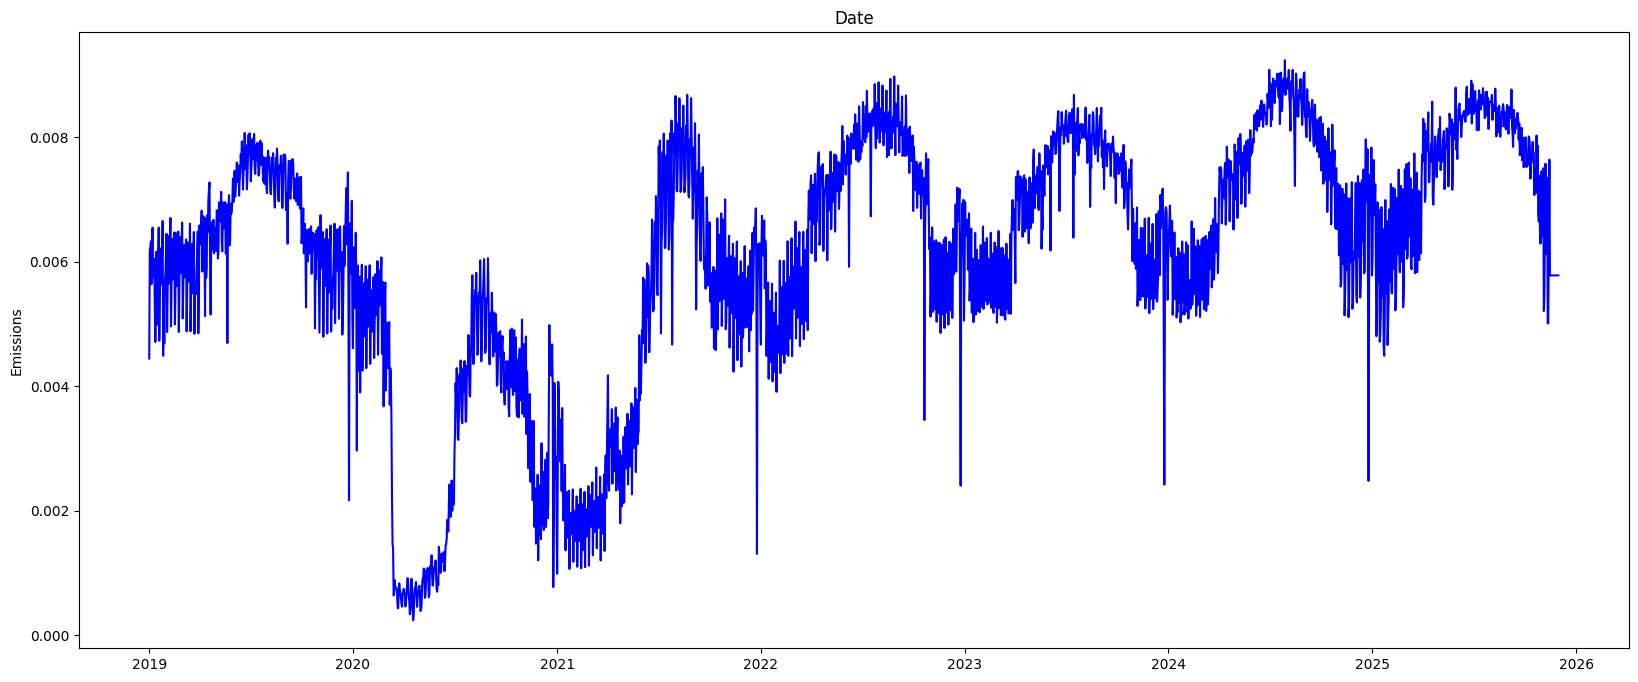

In [418]:
italy_domestic_aviation_df = italy_domestic_aviation_df.set_index('date')

plt.figure(figsize=(20,8))
plt.plot(italy_domestic_aviation_df.index, italy_domestic_aviation_df['value'], color='blue')
plt.ylabel('Emissions')
plt.title('Date')

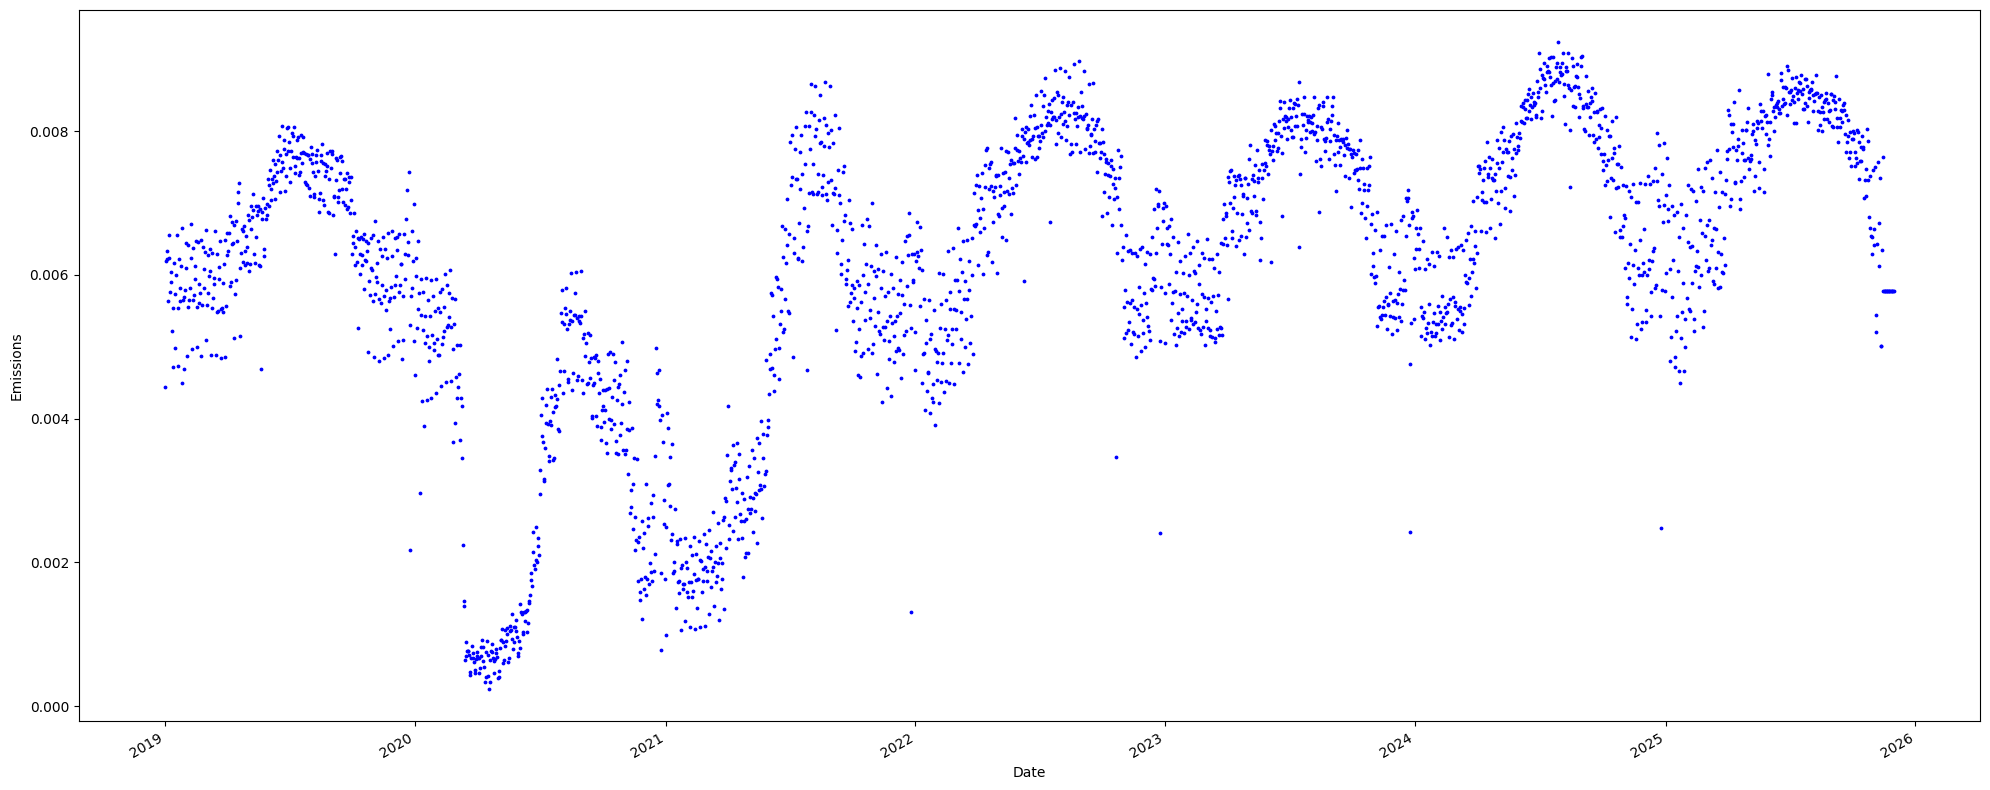

In [419]:
fig, ax = plt.subplots(figsize=(20,8))
ax.scatter(italy_domestic_aviation_df.index, italy_domestic_aviation_df['value'], color='blue', s=3, label='Inlier')
ax.set_xlabel('Date')
ax.set_ylabel('Emissions')
plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

In [420]:
median = np.median(italy_domestic_aviation_df['value'])
print("Median:", median)

Median: 0.006423655


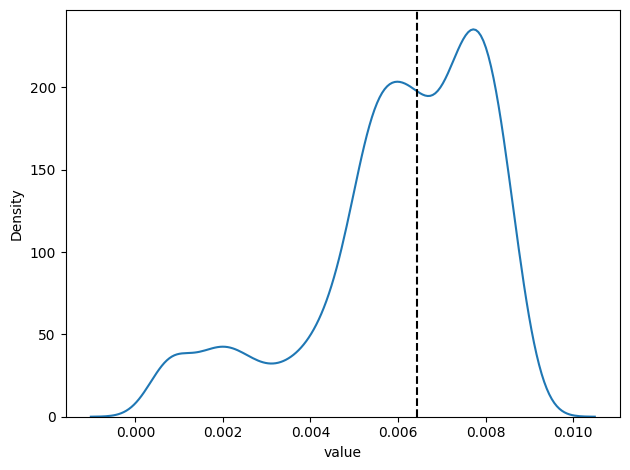

In [421]:
sns.kdeplot(italy_domestic_aviation_df['value']);
plt.grid(False)
plt.axvline(median, 0, 1, c='black', ls='--')
plt.tight_layout()

In [422]:
def seasonal_plot(df, season='year', index='month', column=None):
    if column == None:
        column = df.columns[0]

    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)

    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))
    plt.title(f'Seasonal Plot for {column} by {index} and {season}')
    plt.xlabel(index.capitalize())
    plt.ylabel(column.capitalize())
    plt.legend(title=season.capitalize())
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

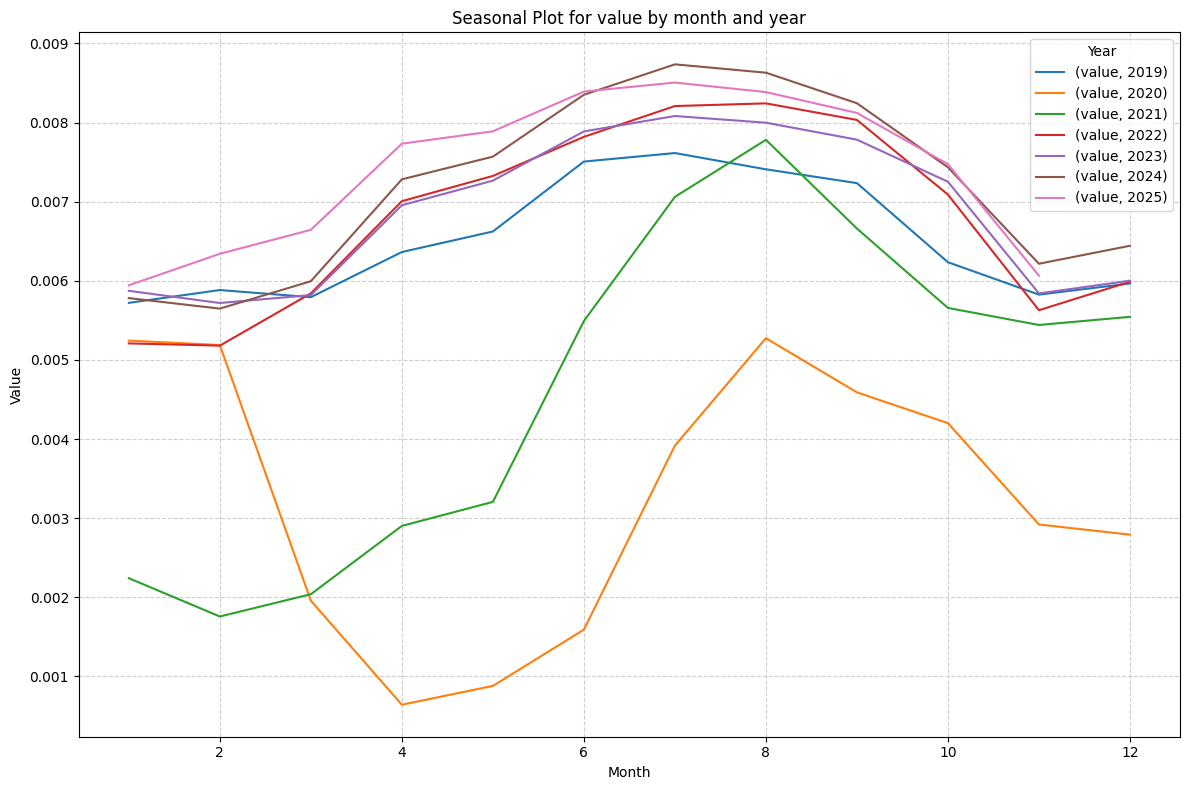

In [423]:
italy_domestic_aviation_df['year'] = italy_domestic_aviation_df.index.year
italy_domestic_aviation_df['month'] = italy_domestic_aviation_df.index.month

seasonal_plot(italy_domestic_aviation_df, season='year', index='month', column='value')

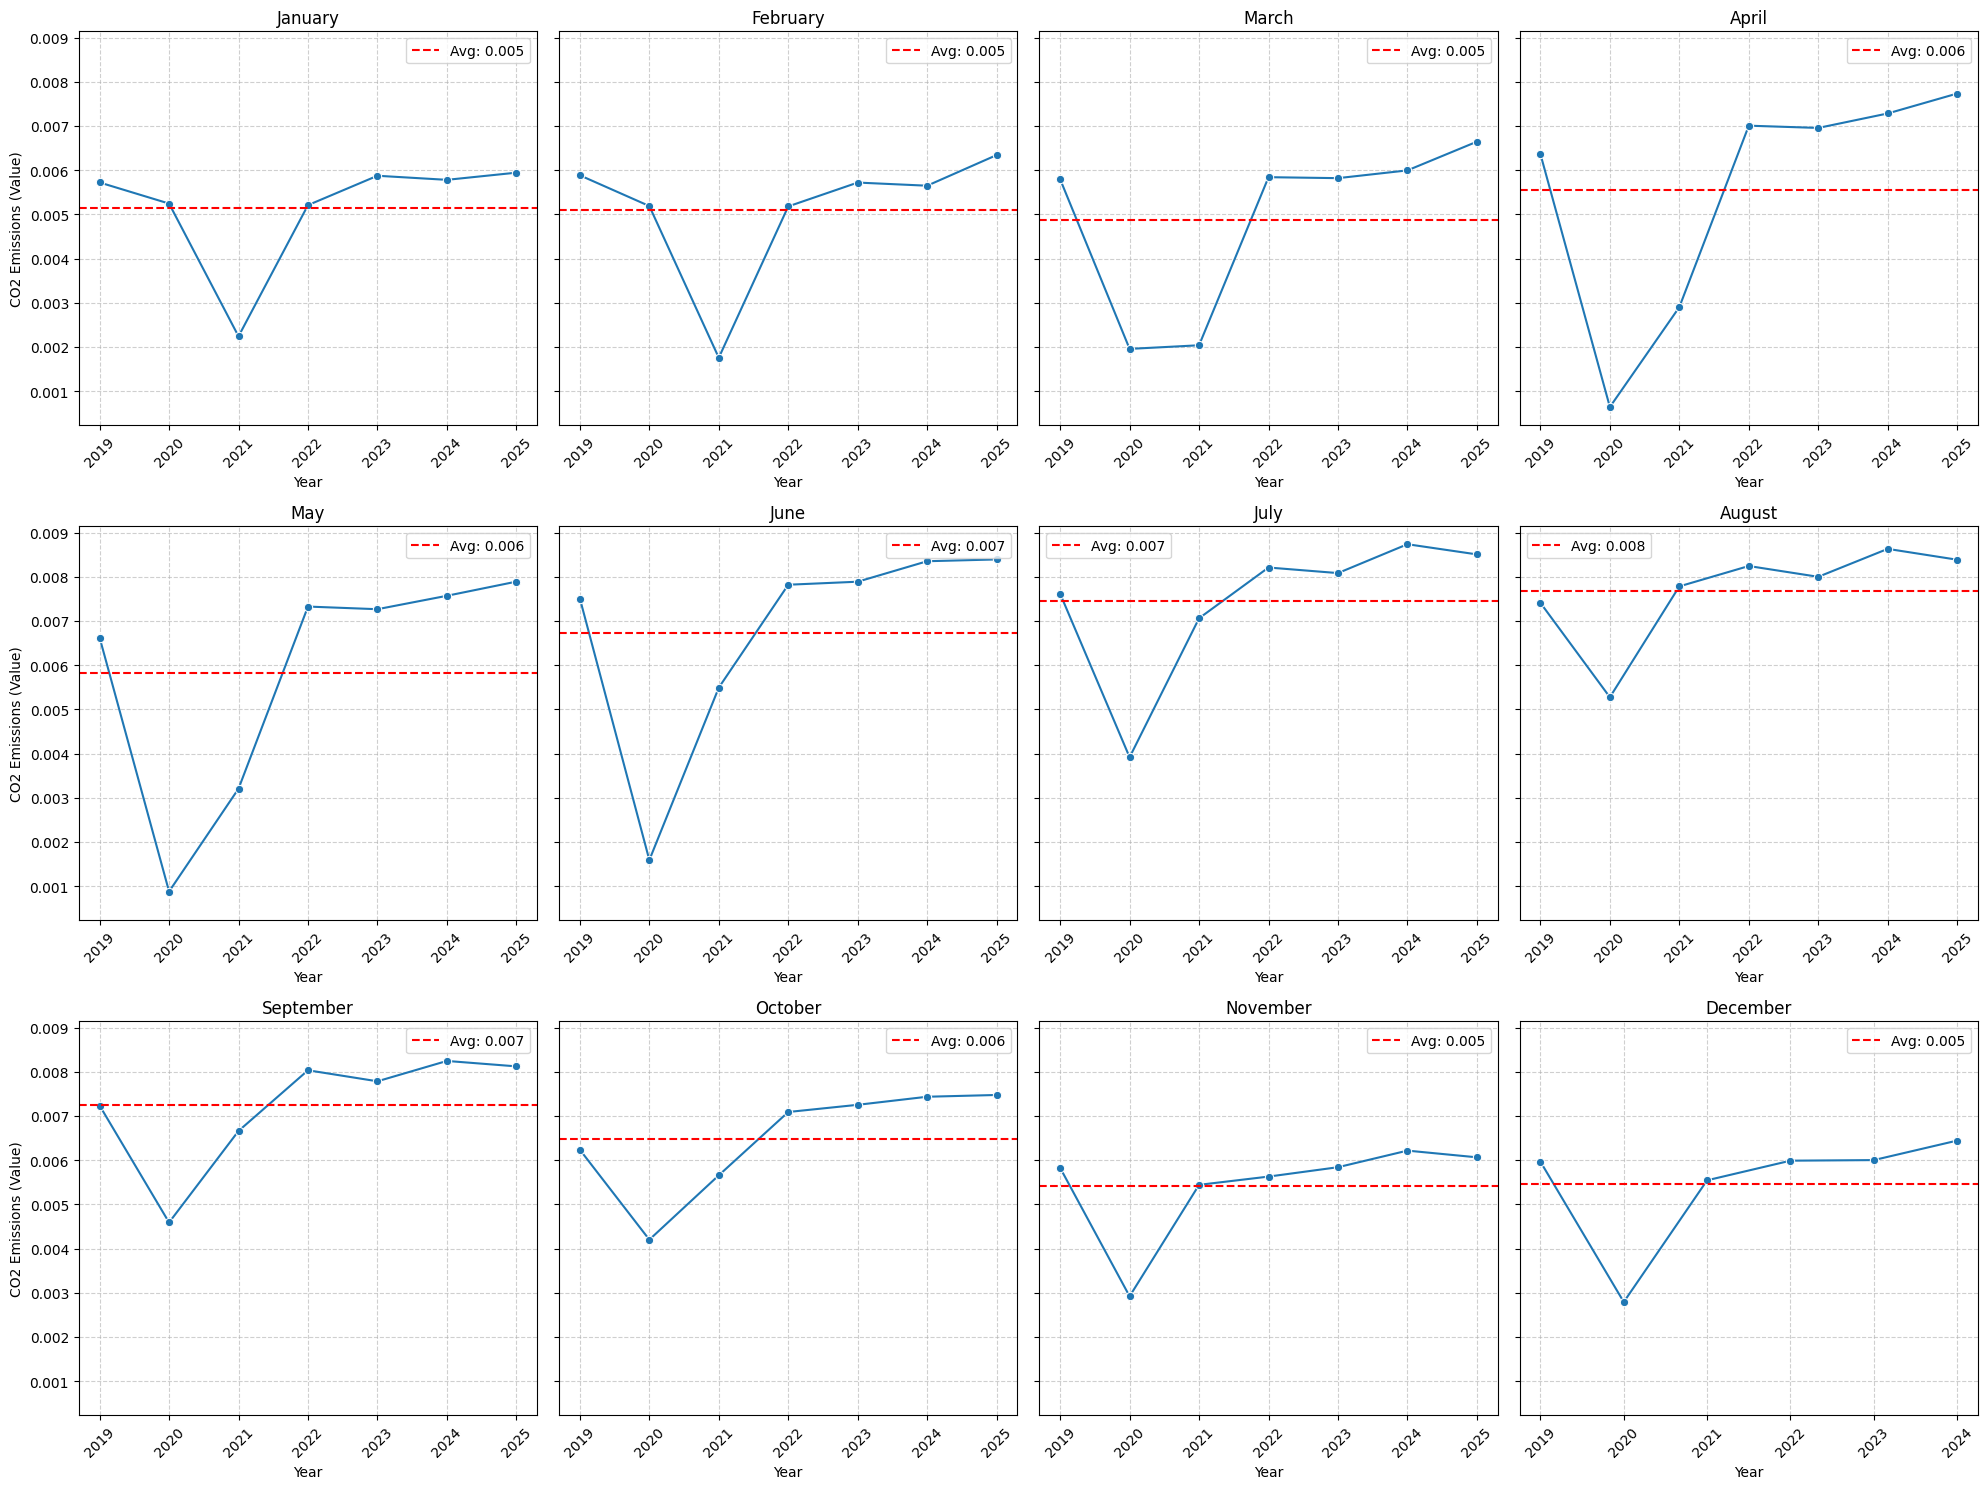

In [424]:
italy_domestic_aviation_monthly = italy_domestic_aviation_df.groupby(['month', 'year'])['value'].mean().reset_index()

fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
axes = axes.flatten()

months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

for i, month_num in enumerate(range(1, 13)):
    ax = axes[i]

    df_month = italy_domestic_aviation_monthly[italy_domestic_aviation_monthly['month'] == month_num]

    sns.lineplot(x='year', y='value', data=df_month, ax=ax, marker='o')

    mean_value = df_month['value'].mean()
    ax.axhline(mean_value, color='red', linestyle='--', label=f'Avg: {mean_value:.3f}')

    ax.set_title(months[month_num-1])
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2 Emissions (Value)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

plt.tight_layout()
plt.show()

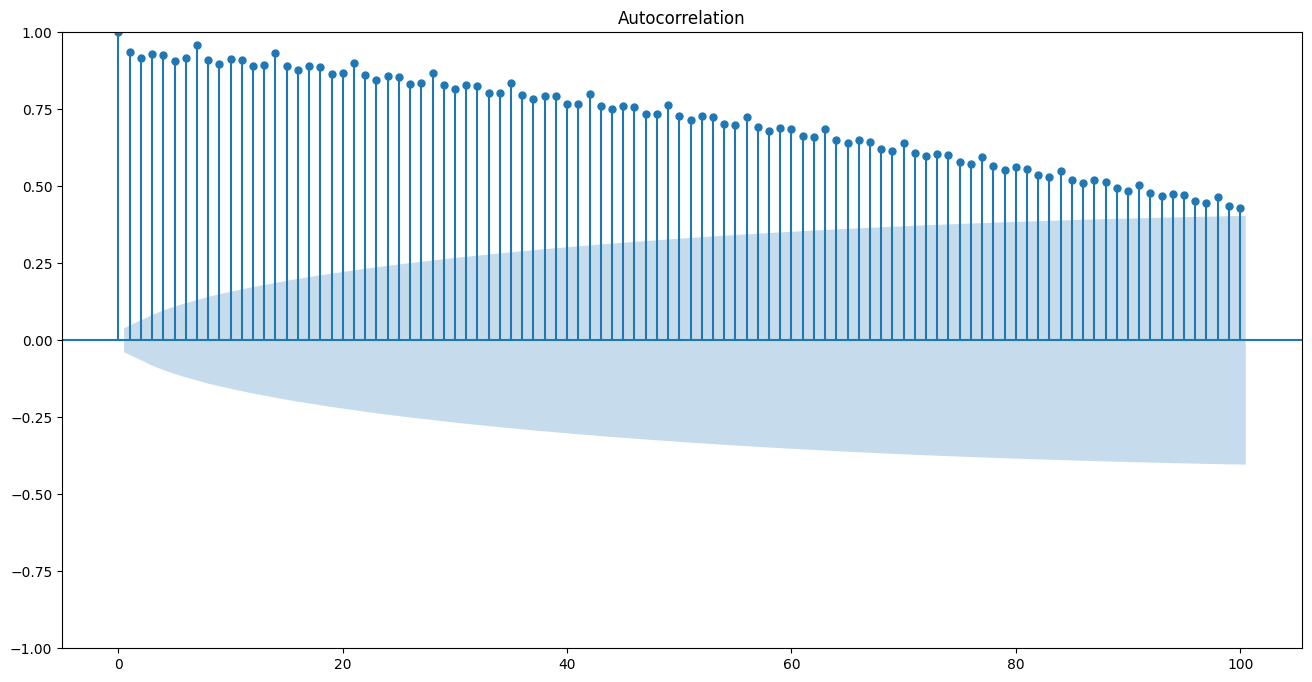

In [425]:
f, ax = plt.subplots(figsize=(16, 8))
plot_acf(italy_domestic_aviation_df['value'], lags=100, ax=ax)
plt.show()

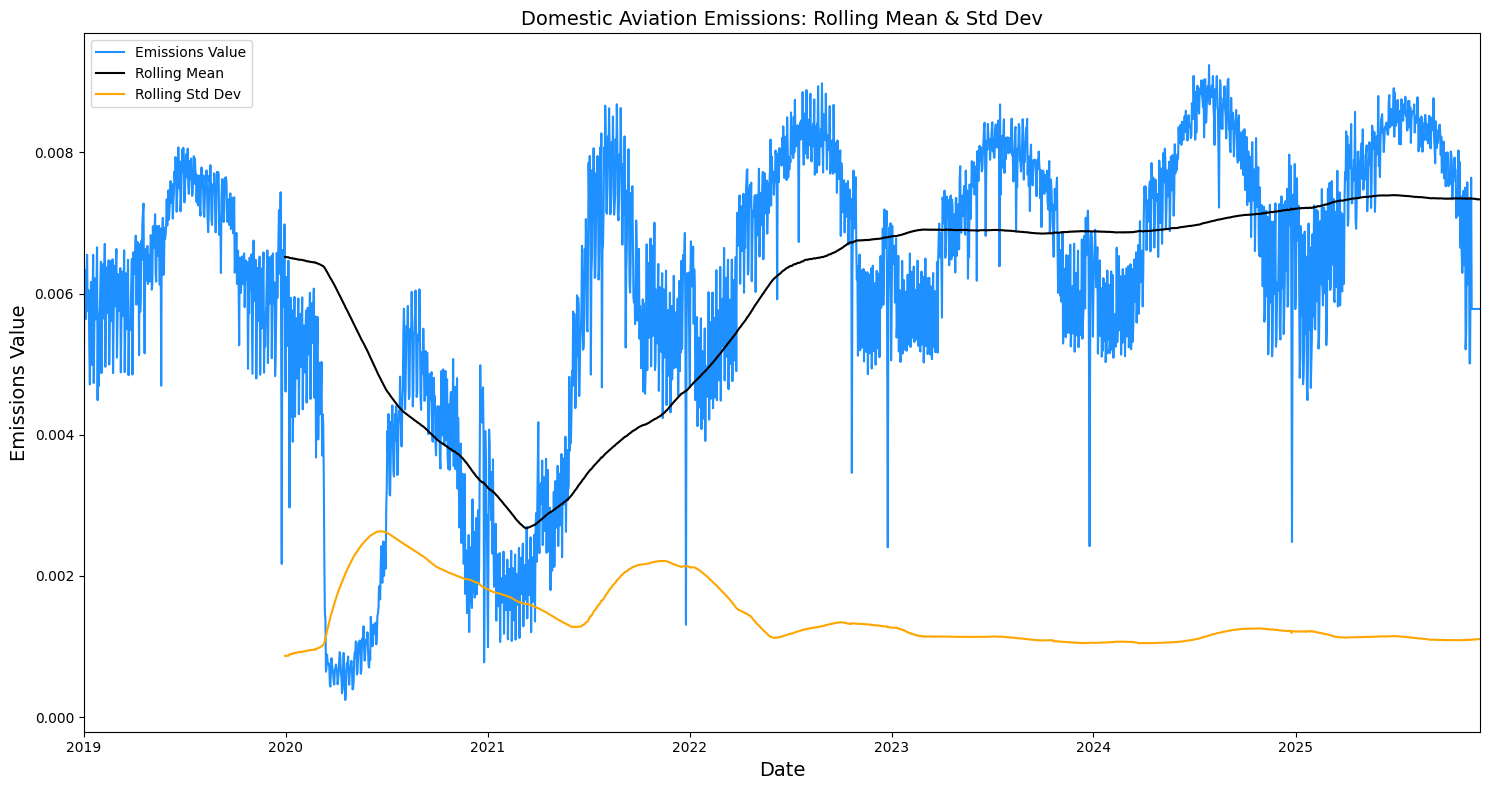

In [426]:
rolling_window = 365
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value'], ax=ax, color='dodgerblue', label='Emissions Value')
sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value'].rolling(rolling_window).mean(), ax=ax, color='black', label='Rolling Mean')
sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value'].rolling(rolling_window).std(), ax=ax, color='orange', label='Rolling Std Dev')
ax.set_title('Domestic Aviation Emissions: Rolling Mean & Std Dev', fontsize=14)
ax.set_ylabel(ylabel='Emissions Value', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.legend()

min_date = italy_domestic_aviation_df.index.min().date()
max_date = italy_domestic_aviation_df.index.max().date()
ax.set_xlim([min_date, max_date])

plt.tight_layout()
plt.show()

In [427]:
italy_domestic_aviation_df['value_log'] = np.log1p(
    italy_domestic_aviation_df['value']
)
display(italy_domestic_aviation_df.head())

,value,year,month,value_log
date,,,,
2019-01-01,0.004446,2019,1,0.004436
2019-01-02,0.006196,2019,1,0.006177
2019-01-03,0.006216,2019,1,0.006197
2019-01-04,0.006328,2019,1,0.006308
2019-01-05,0.005640,2019,1,0.005624


In [428]:
italy_domestic_aviation_df['value_diff_1'] = (
    italy_domestic_aviation_df['value_log'].diff()
)
display(italy_domestic_aviation_df.head())

,value,year,month,value_log,value_diff_1
date,,,,,
2019-01-01,0.004446,2019,1,0.004436,NaN
2019-01-02,0.006196,2019,1,0.006177,0.001741
2019-01-03,0.006216,2019,1,0.006197,0.000020
2019-01-04,0.006328,2019,1,0.006308,0.000111
2019-01-05,0.005640,2019,1,0.005624,-0.000684


In [429]:
italy_domestic_aviation_df = italy_domestic_aviation_df.dropna()
display(italy_domestic_aviation_df.head())

,value,year,month,value_log,value_diff_1
date,,,,,
2019-01-02,0.006196,2019,1,0.006177,0.001741
2019-01-03,0.006216,2019,1,0.006197,0.000020
2019-01-04,0.006328,2019,1,0.006308,0.000111
2019-01-05,0.005640,2019,1,0.005624,-0.000684
2019-01-06,0.006239,2019,1,0.006220,0.000596


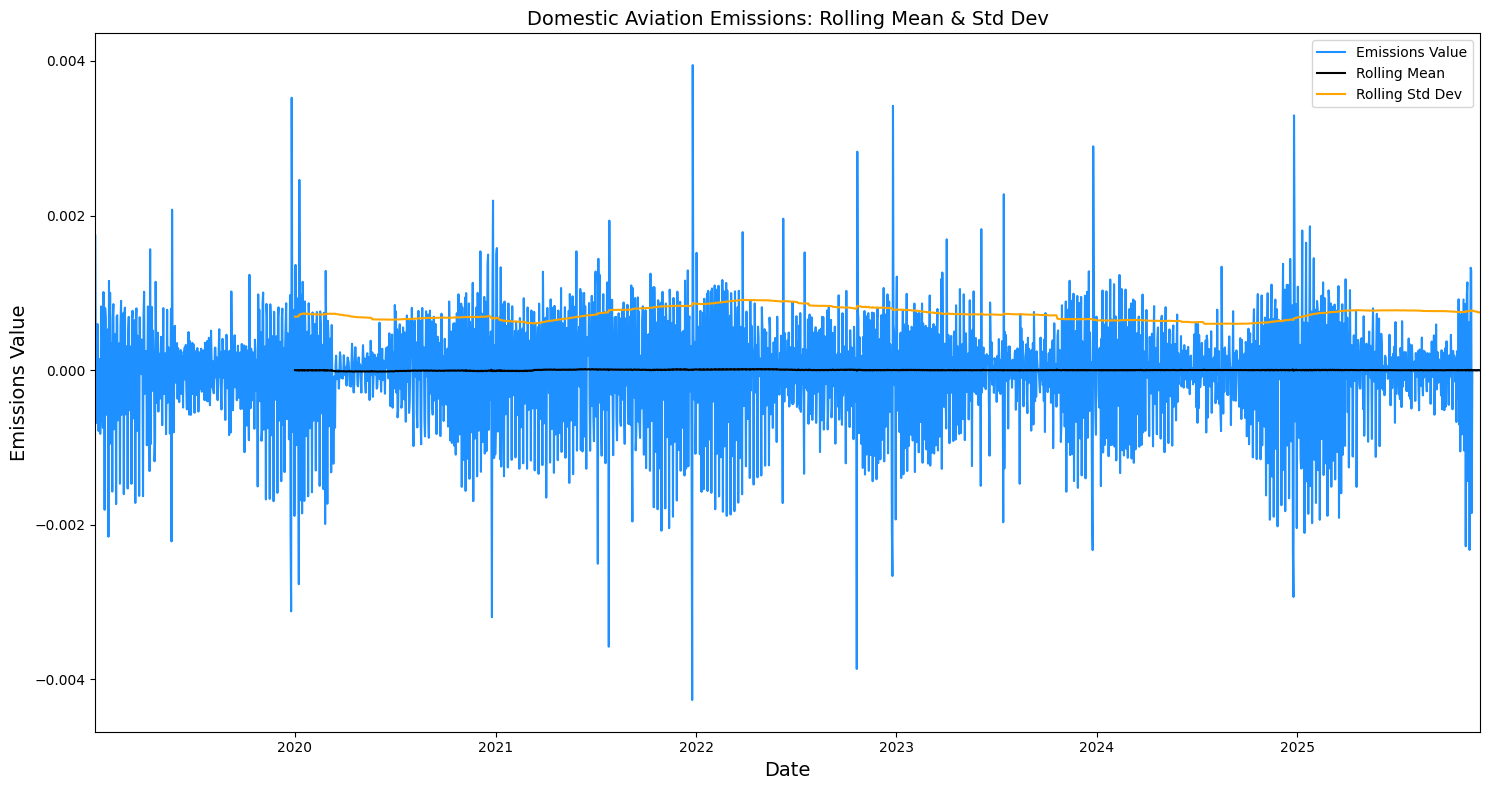

In [430]:
rolling_window = 365
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value_diff_1'], ax=ax, color='dodgerblue', label='Emissions Value')
sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value_diff_1'].rolling(rolling_window).mean(), ax=ax, color='black', label='Rolling Mean')
sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value_diff_1'].rolling(rolling_window).std(), ax=ax, color='orange', label='Rolling Std Dev')
ax.set_title('Domestic Aviation Emissions: Rolling Mean & Std Dev', fontsize=14)
ax.set_ylabel(ylabel='Emissions Value', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.legend()

min_date = italy_domestic_aviation_df.index.min().date()
max_date = italy_domestic_aviation_df.index.max().date()
ax.set_xlim([min_date, max_date])

plt.tight_layout()
plt.show()

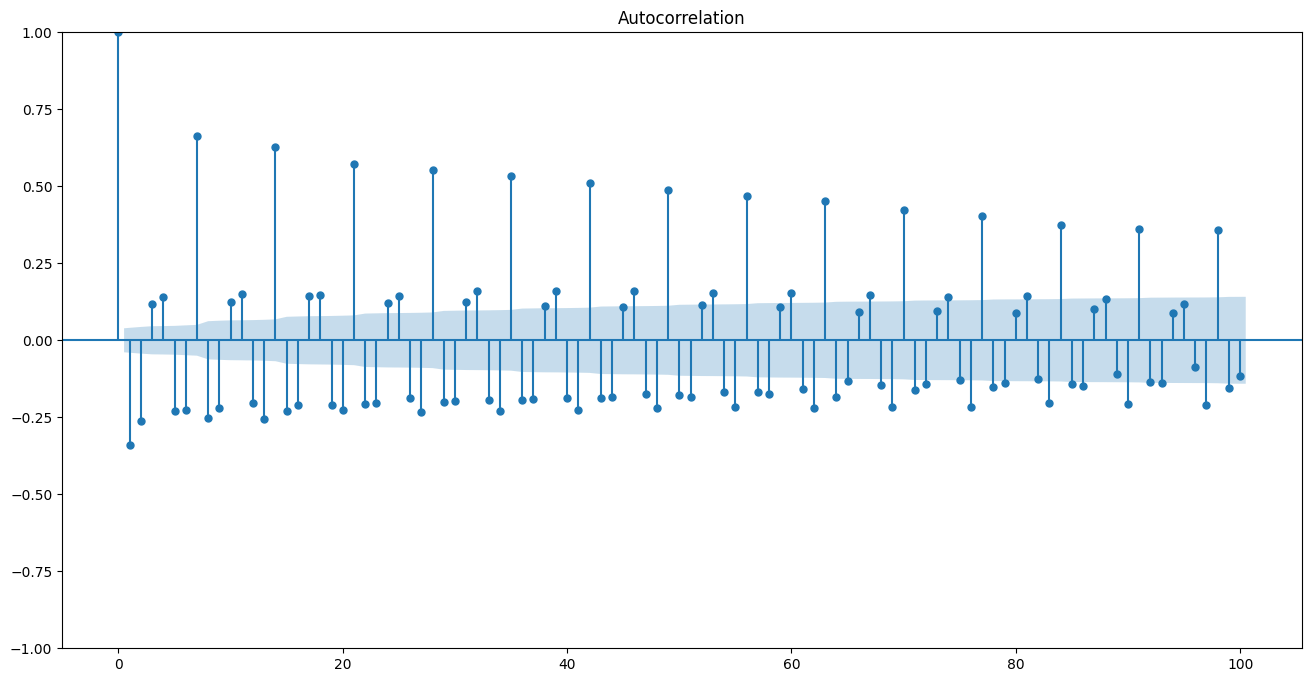

In [431]:
f, ax = plt.subplots(figsize=(16, 8))
plot_acf(italy_domestic_aviation_df['value_diff_1'], lags=100, ax=ax)
plt.show()

In [432]:
italy_domestic_aviation_df['value_diff_2'] = (
    italy_domestic_aviation_df['value_log'].diff().diff()
)
display(italy_domestic_aviation_df.head())

,value,year,month,value_log,value_diff_1,value_diff_2
date,,,,,,
2019-01-02,0.006196,2019,1,0.006177,0.001741,NaN
2019-01-03,0.006216,2019,1,0.006197,0.000020,NaN
2019-01-04,0.006328,2019,1,0.006308,0.000111,0.000091
2019-01-05,0.005640,2019,1,0.005624,-0.000684,-0.000795
2019-01-06,0.006239,2019,1,0.006220,0.000596,0.001280


In [433]:
italy_domestic_aviation_df = italy_domestic_aviation_df.dropna()
display(italy_domestic_aviation_df.head())

,value,year,month,value_log,value_diff_1,value_diff_2
date,,,,,,
2019-01-04,0.006328,2019,1,0.006308,0.000111,0.000091
2019-01-05,0.005640,2019,1,0.005624,-0.000684,-0.000795
2019-01-06,0.006239,2019,1,0.006220,0.000596,0.001280
2019-01-07,0.006548,2019,1,0.006527,0.000307,-0.000289
2019-01-08,0.005757,2019,1,0.005740,-0.000787,-0.001094


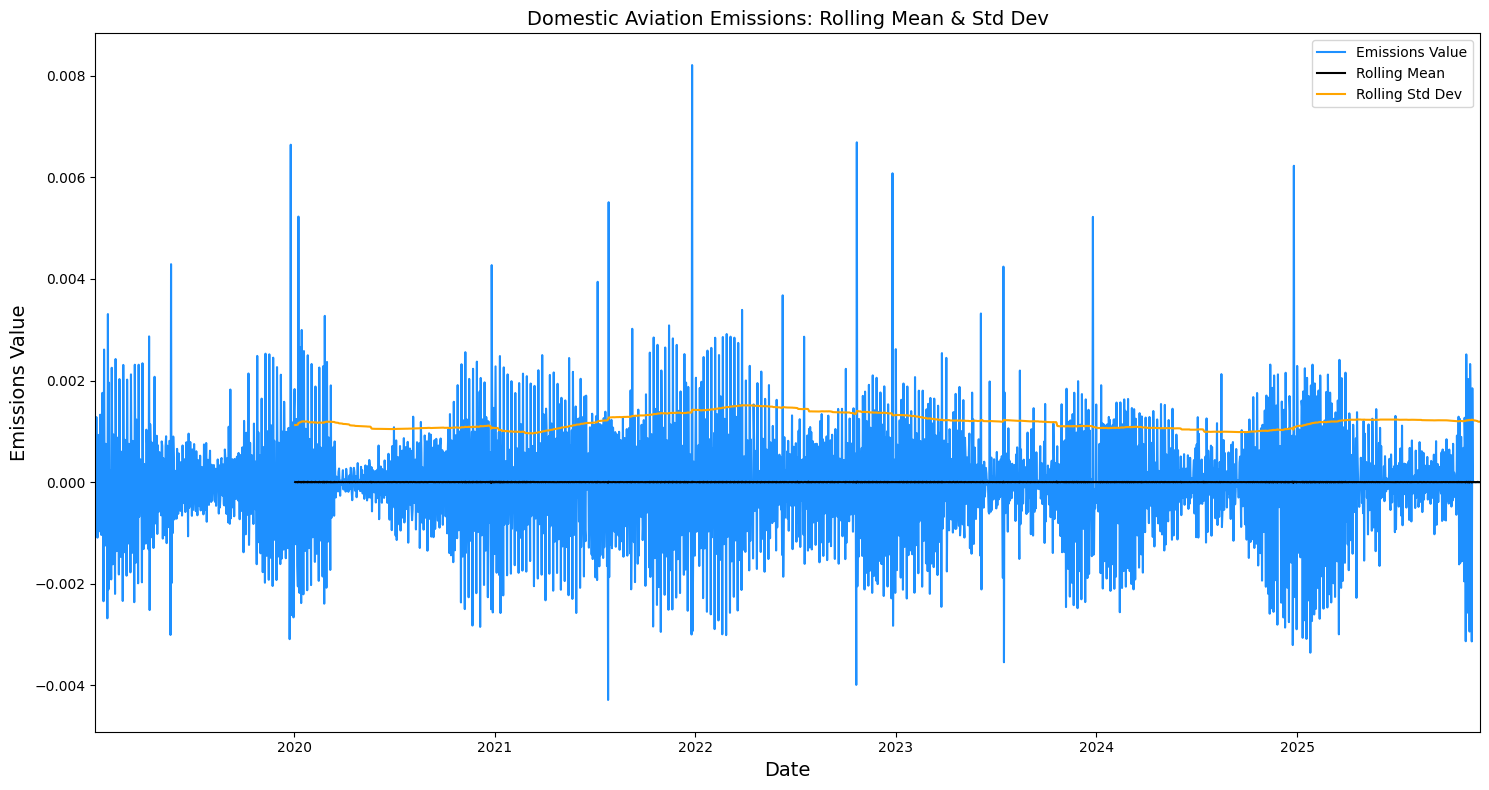

In [434]:
rolling_window = 365
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))

sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value_diff_2'], ax=ax, color='dodgerblue', label='Emissions Value')
sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value_diff_2'].rolling(rolling_window).mean(), ax=ax, color='black', label='Rolling Mean')
sns.lineplot(x=italy_domestic_aviation_df.index, y=italy_domestic_aviation_df['value_diff_2'].rolling(rolling_window).std(), ax=ax, color='orange', label='Rolling Std Dev')
ax.set_title('Domestic Aviation Emissions: Rolling Mean & Std Dev', fontsize=14)
ax.set_ylabel(ylabel='Emissions Value', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.legend()

min_date = italy_domestic_aviation_df.index.min().date()
max_date = italy_domestic_aviation_df.index.max().date()
ax.set_xlim([min_date, max_date])

plt.tight_layout()
plt.show()

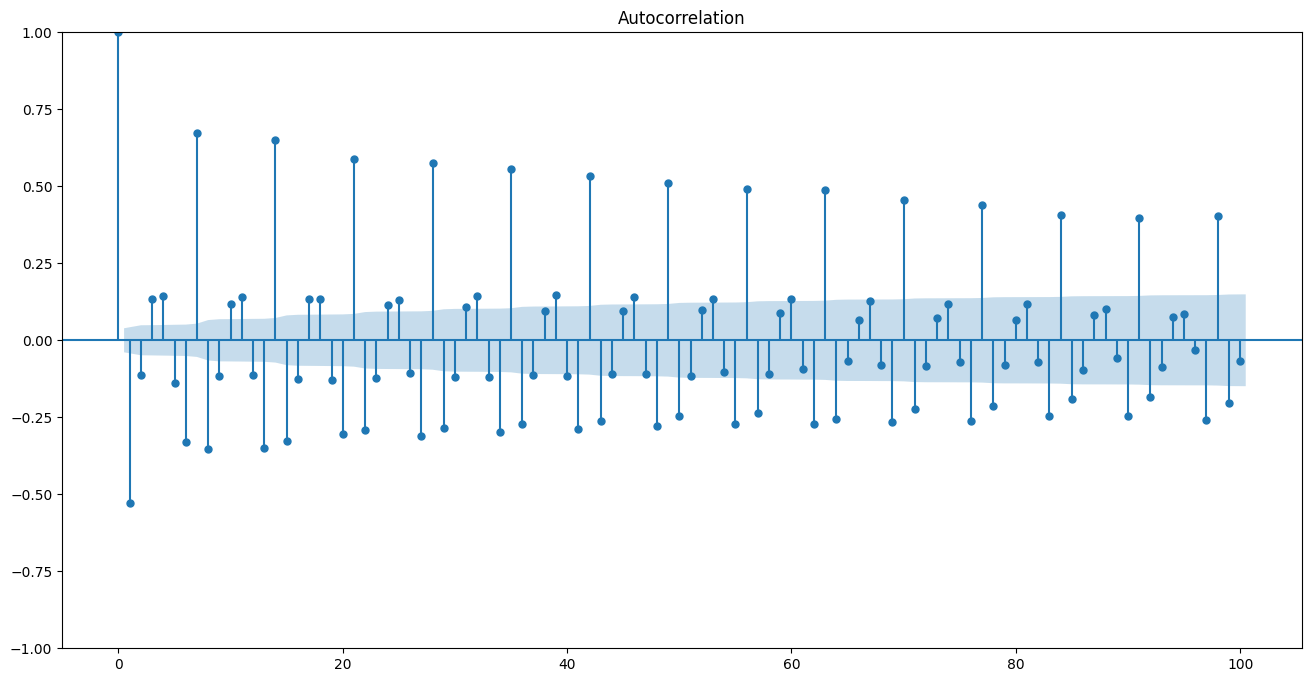

In [435]:
f, ax = plt.subplots(figsize=(16, 8))
plot_acf(italy_domestic_aviation_df['value_diff_2'], lags=100, ax=ax)
plt.show()

In [436]:
n_estimators = 100
contamination = 0.02
sample_size = 256

,value,year,month,value_log,value_diff_1,value_diff_2,outlier_label,outlier_score,is_outlier
date,,,,,,,,,
2019-01-04,0.006328,2019,1,0.006308,0.000111,0.000091,1,0.173341,False
2019-01-05,0.005640,2019,1,0.005624,-0.000684,-0.000795,1,0.186480,False
2019-01-06,0.006239,2019,1,0.006220,0.000596,0.001280,1,0.182688,False
2019-01-07,0.006548,2019,1,0.006527,0.000307,-0.000289,1,0.172990,False
2019-01-08,0.005757,2019,1,0.005740,-0.000787,-0.001094,1,0.196010,False


Detected 51 outliers (2.02% of the dataset) in the 'value' column using Isolation Forest method.



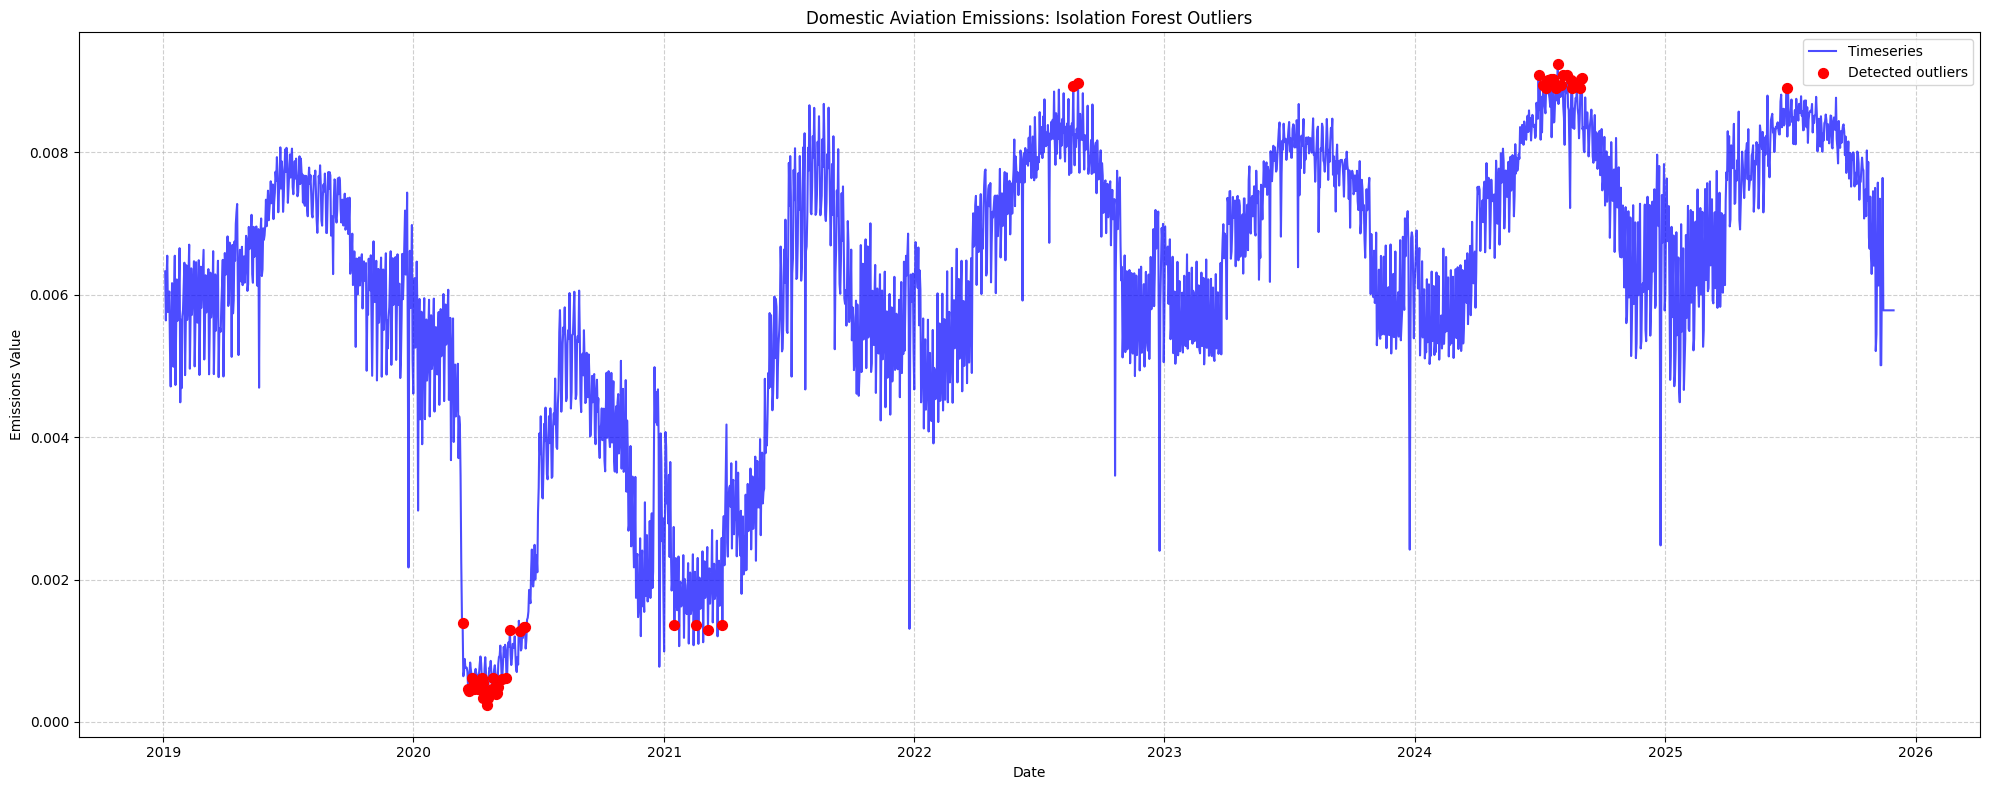

In [437]:
df_temp_1 = italy_domestic_aviation_df.copy().sort_index()

isolation_forest = IsolationForest(
    n_estimators = n_estimators,
    max_samples = sample_size,
    contamination=contamination,
    random_state=42
)

df_temp_1['outlier_label'] = isolation_forest.fit_predict(df_temp_1[['value']])
df_temp_1['outlier_score'] = isolation_forest.decision_function(df_temp_1[['value']])

df_temp_1['is_outlier'] = df_temp_1['outlier_label'] == -1

outliers_iso_forest = df_temp_1[df_temp_1['is_outlier']]
iso_forest_outlier_percent = (len(outliers_iso_forest) / df_temp_1.shape[0]) * 100

display(df_temp_1.head())

print(f"Detected {len(outliers_iso_forest)} outliers ({iso_forest_outlier_percent:.2f}% of the dataset) in the 'value' column using Isolation Forest method.\n")

plt.figure(figsize=(20, 8))
plt.plot(df_temp_1.index, df_temp_1['value'], label='Timeseries', color='blue', alpha=0.7)
plt.scatter(outliers_iso_forest.index, outliers_iso_forest['value'], color='red', label='Detected outliers', s=50, zorder=5)
plt.title('Domestic Aviation Emissions: Isolation Forest Outliers')
plt.xlabel('Date')
plt.ylabel('Emissions Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Detected 50 shape-outlier windows out of 2494 windows.
Break interval estimate:
Start: 2020-03-20 00:00:00
End  : 2020-05-22 00:00:00


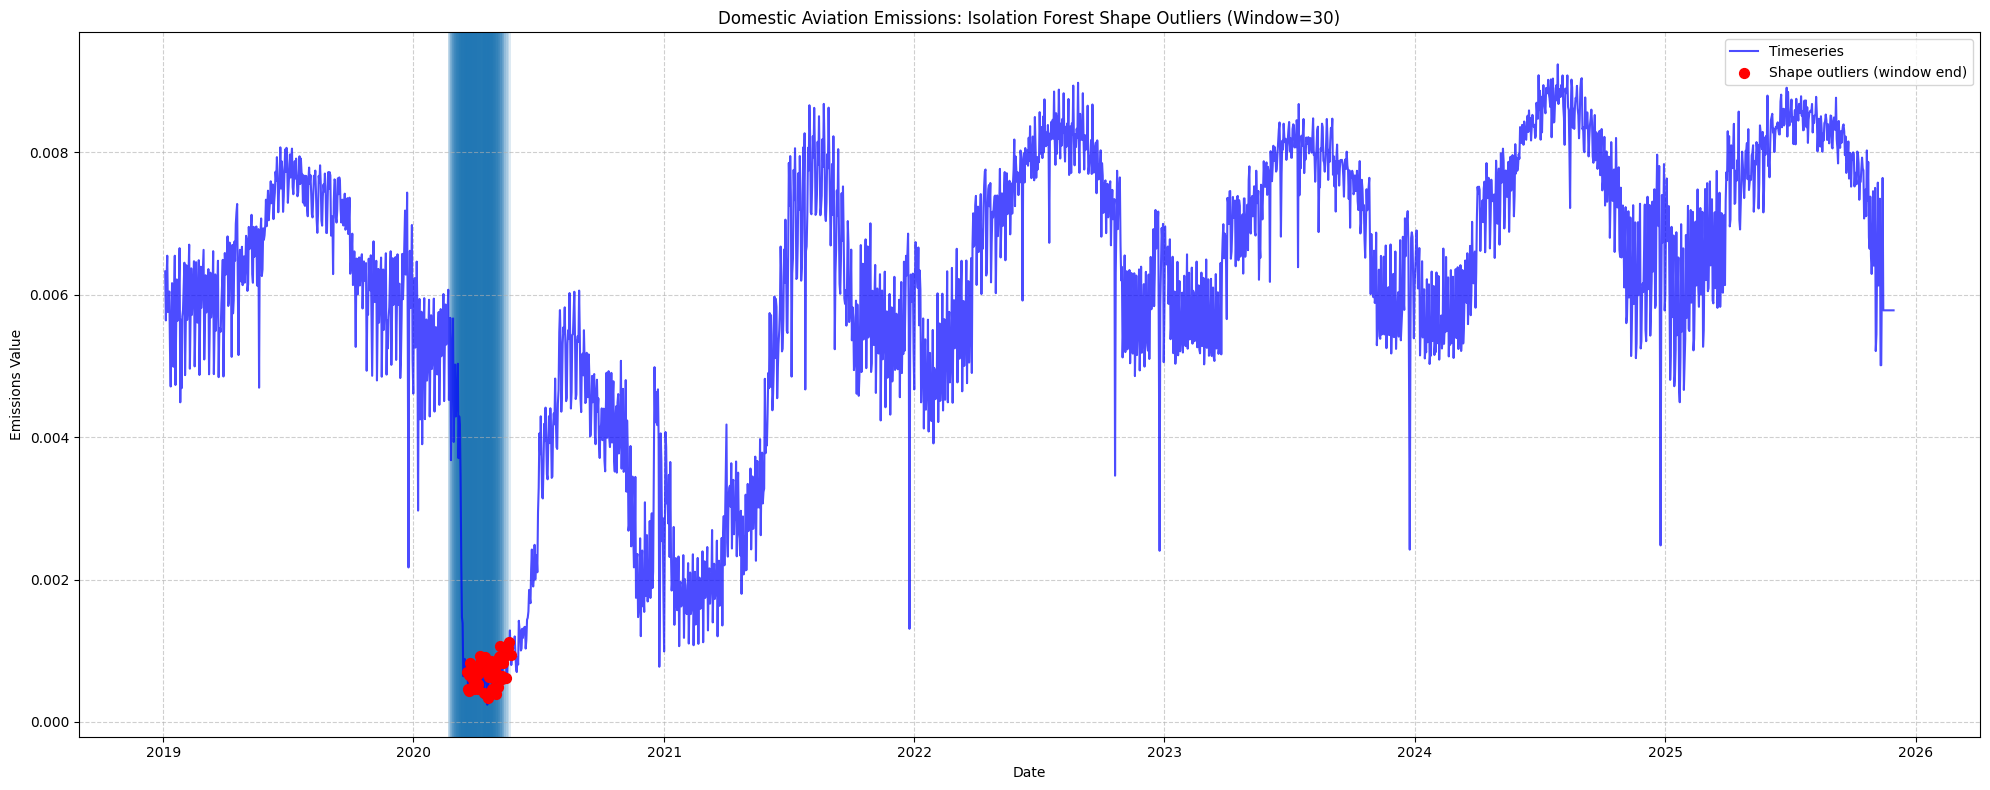

In [438]:
df_temp_2 = italy_domestic_aviation_df.copy().sort_index()

W = 30

y = df_temp_2["value"].astype(float).values

X = np.array([y[i - W + 1 : i + 1] for i in range(W - 1, len(y))])

X_scaled = StandardScaler().fit_transform(X)

iso = IsolationForest(
    n_estimators = n_estimators,
    max_samples = sample_size,
    contamination=contamination,
    random_state=42
)
window_labels = iso.fit_predict(X_scaled)
window_scores = -iso.score_samples(X_scaled)

window_end_index = df_temp_2.index[W - 1:]
df_windows = pd.DataFrame(
    {"outlier_label": window_labels, "score": window_scores},
    index=window_end_index
)

outlier_windows = df_windows[df_windows["outlier_label"] == -1]
print(f"Detected {len(outlier_windows)} shape-outlier windows out of {len(df_windows)} windows.")
print("Break interval estimate:")
print("Start:", outlier_windows.index.min())
print("End  :", outlier_windows.index.max())

plt.figure(figsize=(20, 8))
plt.plot(df_temp_2.index, df_temp_2["value"], color='blue', label="Timeseries", alpha=0.7)

plt.scatter(
    outlier_windows.index,
    df_temp_2.loc[outlier_windows.index, "value"],
    color="red",
    s=50,
    zorder=5,
    label="Shape outliers (window end)"
)

for t_end in outlier_windows.index:
    i_end = df_temp_2.index.get_loc(t_end)
    t_start = df_temp_2.index[i_end - (W - 1)]
    plt.axvspan(t_start, t_end, alpha=0.15)

plt.title(f"Domestic Aviation Emissions: Isolation Forest Shape Outliers (Window={W})")
plt.xlabel("Date")
plt.ylabel("Emissions Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [439]:
country_df = df.copy()
country_domestic_aviation_df = country_df[country_df['sector'] == 'Domestic Aviation']
country_domestic_aviation_df = country_domestic_aviation_df.drop(columns=['sector'], errors='ignore')
country_domestic_aviation_df.head()

,country,date,value
0,Austria,2019-01-01,0.000066
6,Belgium,2019-01-01,0.000010
12,Brazil,2019-01-01,0.019680
18,Bulgaria,2019-01-01,0.000016
24,China,2019-01-01,0.156990


/tmp/ipython-input-3781687719.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='country', y='total_domestic_aviation_emissions', data=top_10_countries, palette='viridis', legend=False)


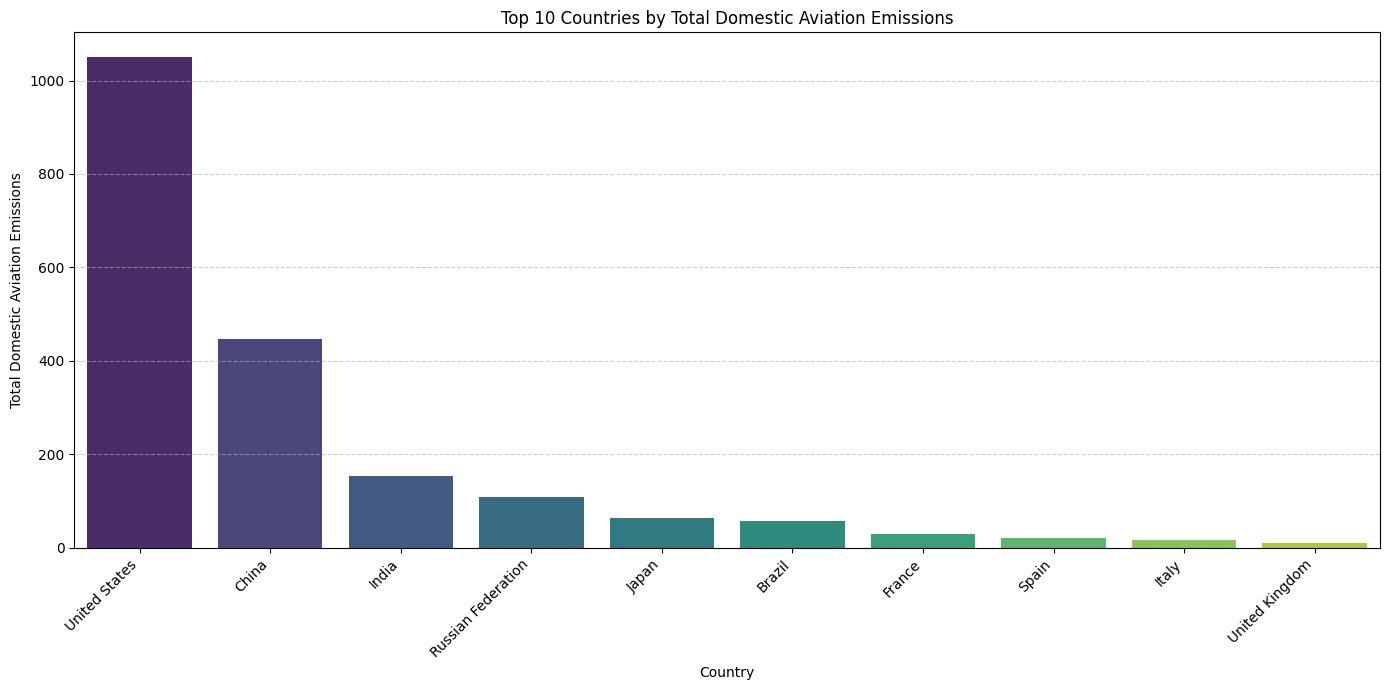

In [440]:
country_emissions = country_domestic_aviation_df.groupby('country')['value'].sum().reset_index()
country_emissions = country_emissions.rename(columns={'value': 'total_domestic_aviation_emissions'})

top_10_countries = country_emissions.sort_values(by='total_domestic_aviation_emissions', ascending=False).head(10)

plt.figure(figsize=(14, 7))
sns.barplot(x='country', y='total_domestic_aviation_emissions', data=top_10_countries, palette='viridis', legend=False)
plt.title('Top 10 Countries by Total Domestic Aviation Emissions')
plt.xlabel('Country')
plt.ylabel('Total Domestic Aviation Emissions')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [441]:
top_10_country_names = top_10_countries['country'].tolist()

country_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'].isin(top_10_country_names)]

print("DataFrame updated to include only top 10 countries by domestic aviation emissions.")

unique_countries_top_10 = country_domestic_aviation_df['country'].unique()
print("Unique Countries:")
for country in unique_countries_top_10:
    print(f"- {country}")



DataFrame updated to include only top 10 countries by domestic aviation emissions.
Unique Countries:
- Brazil
- China
- France
- India
- Italy
- Japan
- Russian Federation
- Spain
- United Kingdom
- United States


/tmp/ipython-input-2004650393.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='country', y='record_count', data=country_record_counts, palette='viridis', legend=False)


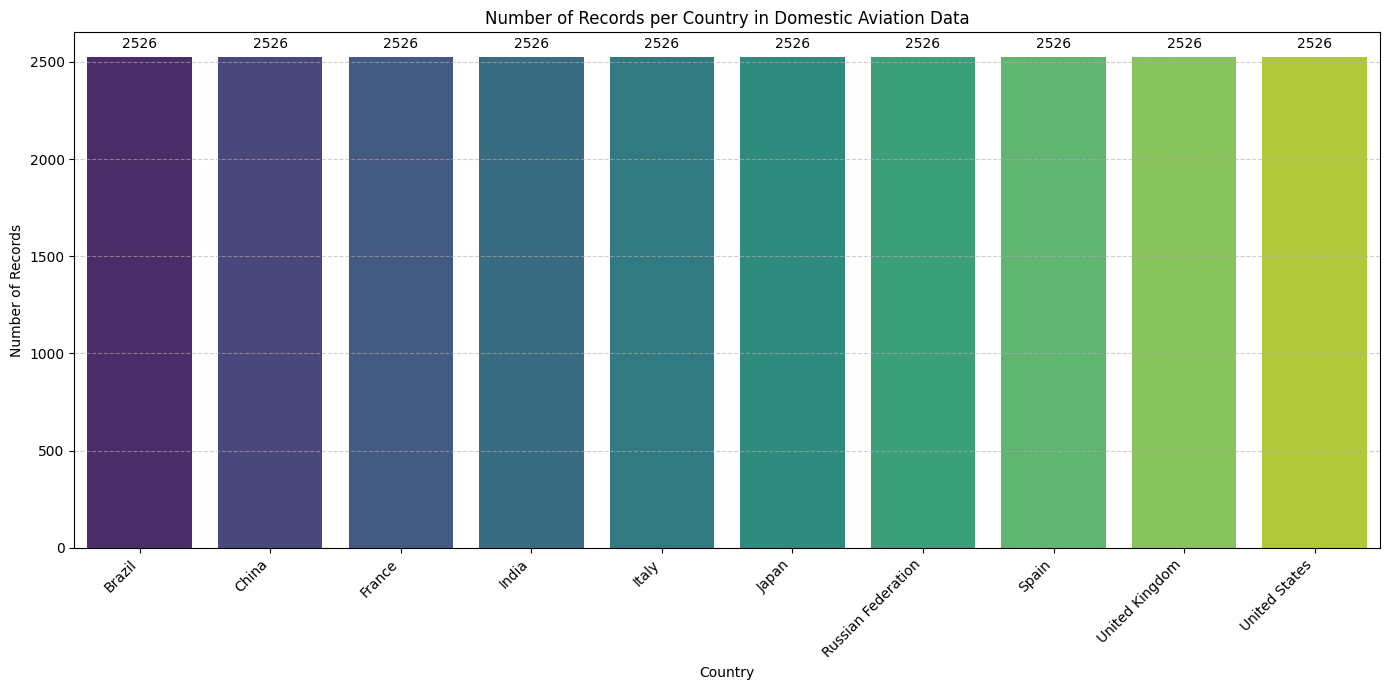

In [442]:
country_record_counts = country_domestic_aviation_df.groupby('country').size().reset_index(name='record_count')

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='country', y='record_count', data=country_record_counts, palette='viridis', legend=False)
plt.title('Number of Records per Country in Domestic Aviation Data')
plt.xlabel('Country')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [443]:
united_states_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'United States'].copy()
china_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'China'].copy()
india_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'India'].copy()
russian_federation_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Russian Federation'].copy()
japan_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Japan'].copy()
brazil_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Brazil'].copy()
france_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'France'].copy()
spain_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Spain'].copy()
italy_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'Italy'].copy()
united_kingdom_domestic_aviation_df = country_domestic_aviation_df[country_domestic_aviation_df['country'] == 'United Kingdom'].copy()

In [444]:
dfs = [
    united_states_domestic_aviation_df.assign(country='United States'),
    china_domestic_aviation_df.assign(country='China'),
    india_domestic_aviation_df.assign(country='India'),
    russian_federation_domestic_aviation_df.assign(country='Russian Federation'),
    japan_domestic_aviation_df.assign(country='Japan'),
    brazil_domestic_aviation_df.assign(country='Brazil'),
    france_domestic_aviation_df.assign(country='France'),
    spain_domestic_aviation_df.assign(country='Spain'),
    italy_domestic_aviation_df.assign(country='Italy'),
    united_kingdom_domestic_aviation_df.assign(country='United Kingdom')
]


In [445]:
monthly = (
    country_domestic_aviation_df
    .set_index("date")
    .groupby("country")["value"]
    .resample("ME")
    .mean()
    .reset_index()
)
display(monthly.head())
display("Shape",monthly.shape)


,country,date,value
0,Brazil,2019-01-31,0.026317
1,Brazil,2019-02-28,0.025289
2,Brazil,2019-03-31,0.023891
3,Brazil,2019-04-30,0.022791
4,Brazil,2019-05-31,0.021467


'Shape'

(830, 3)

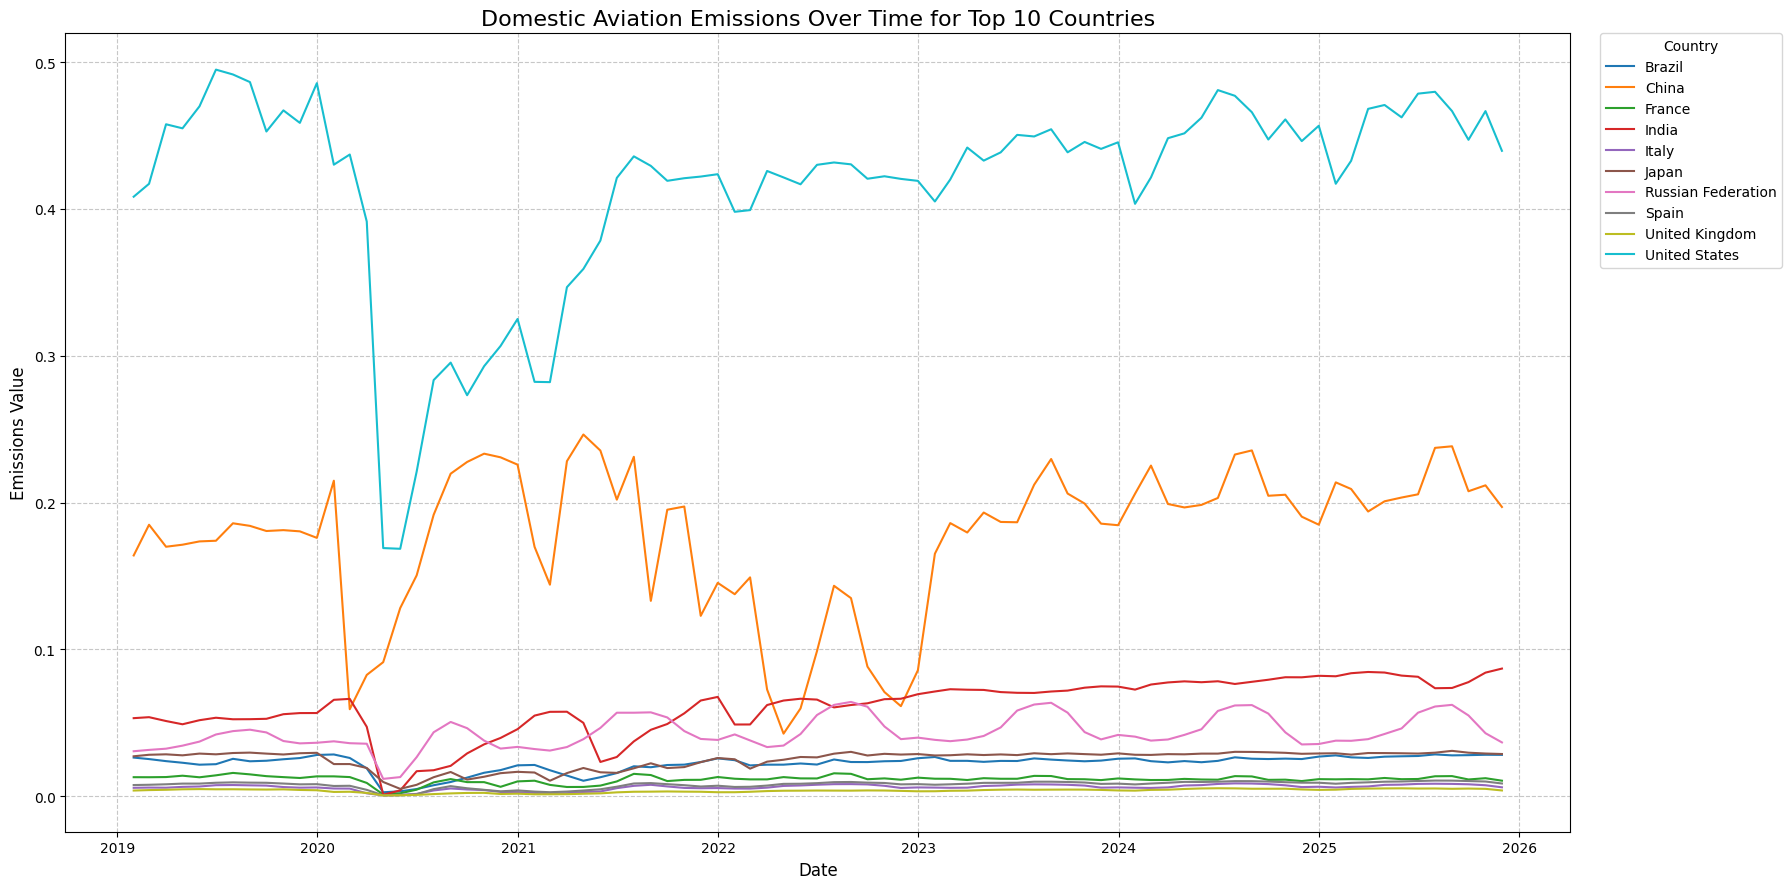

In [446]:
plt.figure(figsize=(18, 9))
sns.lineplot(data=monthly, x='date', y='value', hue='country', palette='tab10', linewidth=1.5)
plt.title('Domestic Aviation Emissions Over Time for Top 10 Countries', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Emissions Value', fontsize=12)
plt.legend(title='Country', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [447]:
pivot = monthly.pivot_table(index="country", columns="date", values="value", aggfunc="mean")

print("Pivot shape (countries x time):", pivot.shape)
display(pivot.head(10))

Pivot shape (countries x time): (10, 83)


date,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,...,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31,2025-11-30
country,,,,,,,,,,,,,,,,,,,,,
Brazil,0.026317,0.025289,0.023891,0.022791,0.021467,0.021810,0.025462,0.023790,0.024160,0.025172,...,0.026470,0.026065,0.026938,0.027201,0.027393,0.028478,0.027817,0.027964,0.028221,0.028165
China,0.163982,0.184888,0.169916,0.171301,0.173545,0.174000,0.185883,0.184133,0.180631,0.181223,...,0.209230,0.193907,0.200863,0.203426,0.205623,0.237261,0.238327,0.207710,0.211745,0.196998
France,0.012954,0.012928,0.013050,0.013967,0.012889,0.014222,0.015870,0.014876,0.013658,0.012998,...,0.011639,0.011480,0.012427,0.011596,0.011727,0.013581,0.013699,0.011396,0.012272,0.010574
India,0.053163,0.053833,0.051205,0.048997,0.051771,0.053449,0.052404,0.052460,0.052723,0.055857,...,0.083773,0.084616,0.084232,0.082146,0.081348,0.073553,0.073725,0.077706,0.084173,0.086930
Italy,0.005721,0.005883,0.005793,0.006363,0.006623,0.007507,0.007614,0.007409,0.007234,0.006235,...,0.006341,0.006644,0.007733,0.007889,0.008391,0.008505,0.008385,0.008121,0.007474,0.006064
Japan,0.027194,0.028227,0.028531,0.027842,0.029031,0.028534,0.029424,0.029693,0.029014,0.028415,...,0.028333,0.029414,0.029380,0.029249,0.029049,0.029644,0.030896,0.029641,0.029073,0.028746
Russian Federation,0.030632,0.031542,0.032368,0.034432,0.037200,0.042050,0.044335,0.045311,0.043439,0.037581,...,0.037737,0.038864,0.042386,0.046159,0.056894,0.061089,0.062230,0.055006,0.042909,0.036643
Spain,0.007610,0.007795,0.008121,0.008585,0.008592,0.009163,0.009437,0.009249,0.009145,0.008625,...,0.009095,0.009457,0.009891,0.010027,0.010363,0.010652,0.010614,0.010335,0.010011,0.008662
United Kingdom,0.003860,0.004172,0.004381,0.004710,0.004845,0.004710,0.004733,0.004610,0.004536,0.004667,...,0.004973,0.005183,0.005311,0.005372,0.005229,0.005270,0.005058,0.005205,0.005016,0.003923


In [448]:
X = pivot.values.astype(float)
X_ts = X[:, :, None]
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_scaled = scaler.fit_transform(X_ts)

In [449]:
pd.DataFrame(X_scaled[:, :, 0]).head(10)

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.689621,0.507379,0.259472,0.064390,-0.170361,-0.109535,0.538071,0.241497,0.307084,0.486610,...,0.716818,0.645021,0.799817,0.846420,0.880399,1.072850,0.955529,0.981693,1.027266,1.017338
1,-0.265971,0.160367,-0.144965,-0.116707,-0.070955,-0.061670,0.180667,0.144977,0.073544,0.085624,...,0.656767,0.344289,0.486152,0.538407,0.583209,1.228399,1.250146,0.625766,0.708052,0.407326
2,0.570010,0.559726,0.606988,0.963556,0.544582,1.062362,1.702478,1.316616,0.843279,0.587120,...,0.058893,-0.002831,0.365070,0.042426,0.093368,0.813410,0.859205,-0.035483,0.304866,-0.354839
3,-0.413909,-0.378543,-0.517118,-0.633556,-0.487313,-0.398811,-0.453934,-0.450943,-0.437080,-0.271833,...,1.200357,1.244835,1.224587,1.114567,1.072500,0.661383,0.670477,0.880440,1.221466,1.366854
4,-0.189172,-0.104917,-0.151768,0.145139,0.280373,0.740312,0.796404,0.689413,0.598595,0.078218,...,0.133572,0.291128,0.858069,0.939431,1.200806,1.260192,1.197553,1.060369,0.723422,-0.010570
5,0.356716,0.522229,0.570916,0.460566,0.650976,0.571374,0.713934,0.757056,0.648280,0.552322,...,0.539141,0.712403,0.707002,0.685987,0.653936,0.749234,0.949854,0.748801,0.657774,0.605350
6,-1.167237,-1.082773,-1.006099,-0.814557,-0.557685,-0.107654,0.104378,0.194948,0.021214,-0.522405,...,-0.507880,-0.403273,-0.076474,0.273625,1.269906,1.659150,1.765093,1.094657,-0.027972,-0.609374
7,-0.104245,-0.025349,0.113656,0.311900,0.314818,0.558509,0.675851,0.595215,0.551172,0.329025,...,0.529551,0.684374,0.869361,0.927420,1.071110,1.194380,1.178093,1.059283,0.920916,0.344640
8,0.104053,0.352236,0.518818,0.780756,0.887779,0.780719,0.798628,0.701005,0.642278,0.746230,...,0.989694,1.156765,1.258185,1.307478,1.193273,1.226060,1.057515,1.173899,1.023913,0.154482
9,-0.109708,0.019918,0.617286,0.576564,0.797484,1.165751,1.117062,1.040735,0.544659,0.756768,...,0.250606,0.771962,0.810833,0.686694,0.924753,0.943158,0.749752,0.461411,0.749428,0.350819


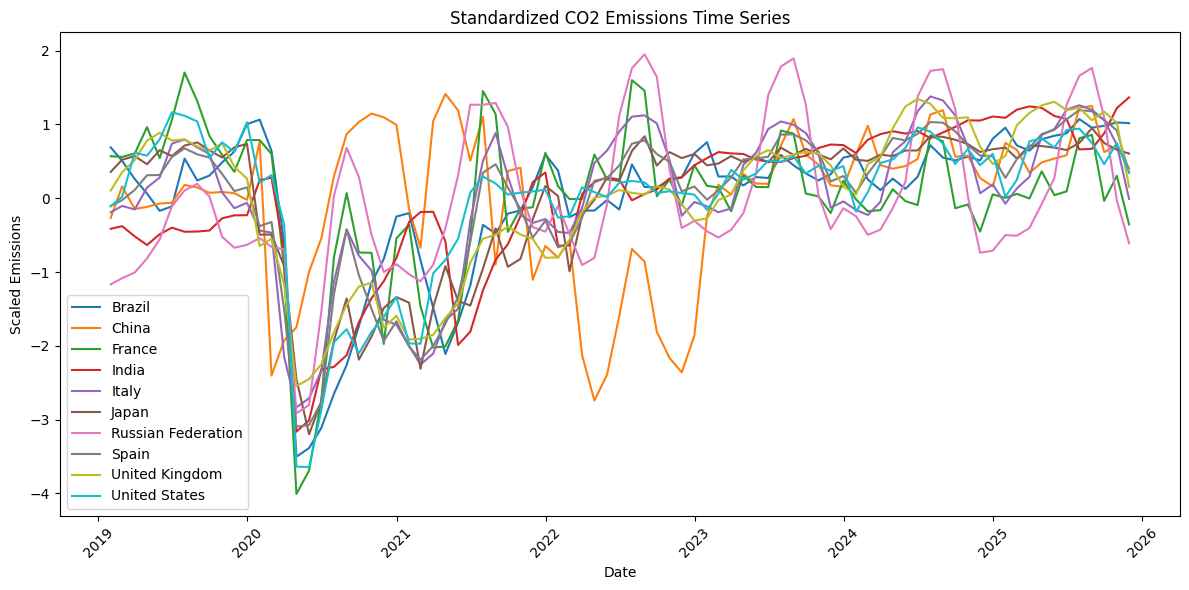

In [450]:
df_plot = pd.DataFrame(
    X_scaled[:, :, 0],
    index=pivot.index,
    columns=pivot.columns
)

plt.figure(figsize=(12,6))

for country in df_plot.index:
    plt.plot(df_plot.columns, df_plot.loc[country], label=country)

plt.title("Standardized CO2 Emissions Time Series")
plt.xlabel("Date")
plt.ylabel("Scaled Emissions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


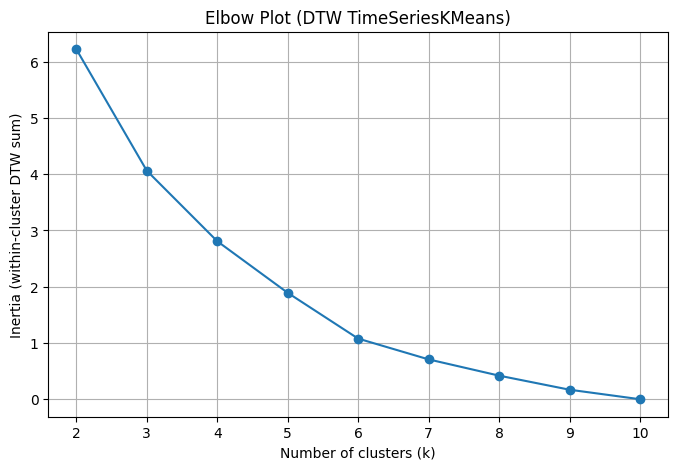

In [451]:
k_values = range(2, 11)
inertias = []

for k in k_values:
    km = TimeSeriesKMeans(
        n_clusters=k,
        metric="dtw",
        max_iter=50,
        n_init=3,
        random_state=42,
        verbose=False
    )
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(list(k_values), inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster DTW sum)")
plt.title("Elbow Plot (DTW TimeSeriesKMeans)")
plt.xticks(list(k_values))
plt.grid(True)
plt.show()


In [452]:
k = 3
dtw_km = TimeSeriesKMeans(
    n_clusters=k,
    metric="dtw",
    random_state=42,
    n_init=5,
    max_iter=50
)

dtw_labels = dtw_km.fit_predict(X_scaled)

cluster_df = pd.DataFrame({"country": pivot.index, "dtw_cluster": dtw_labels})
cluster_df = cluster_df.sort_values("dtw_cluster")
print("DTW clusters:")
display(cluster_df)

DTW clusters:


,country,dtw_cluster
6,Russian Federation,0
0,Brazil,1
3,India,1
2,France,1
5,Japan,1
4,Italy,1
7,Spain,1
8,United Kingdom,1
9,United States,1
1,China,2


In [453]:
for c in range(k):
    members = cluster_df[cluster_df["dtw_cluster"] == c]["country"].tolist()
    print(f"Cluster {c}: {members}")

Cluster 0: ['Russian Federation']
Cluster 1: ['Brazil', 'India', 'France', 'Japan', 'Italy', 'Spain', 'United Kingdom', 'United States']
Cluster 2: ['China']


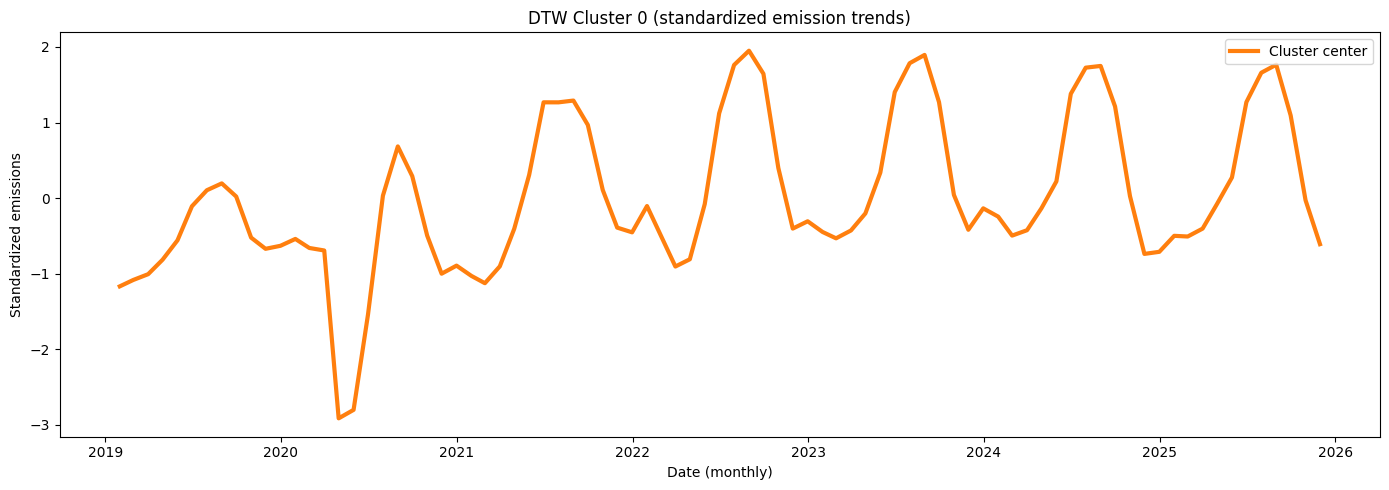

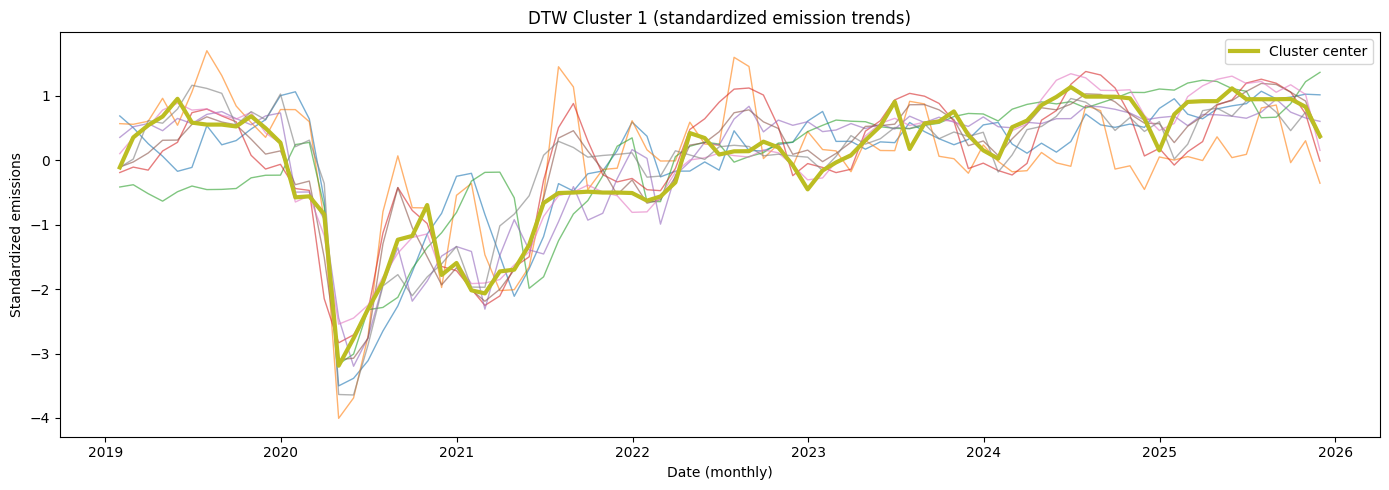

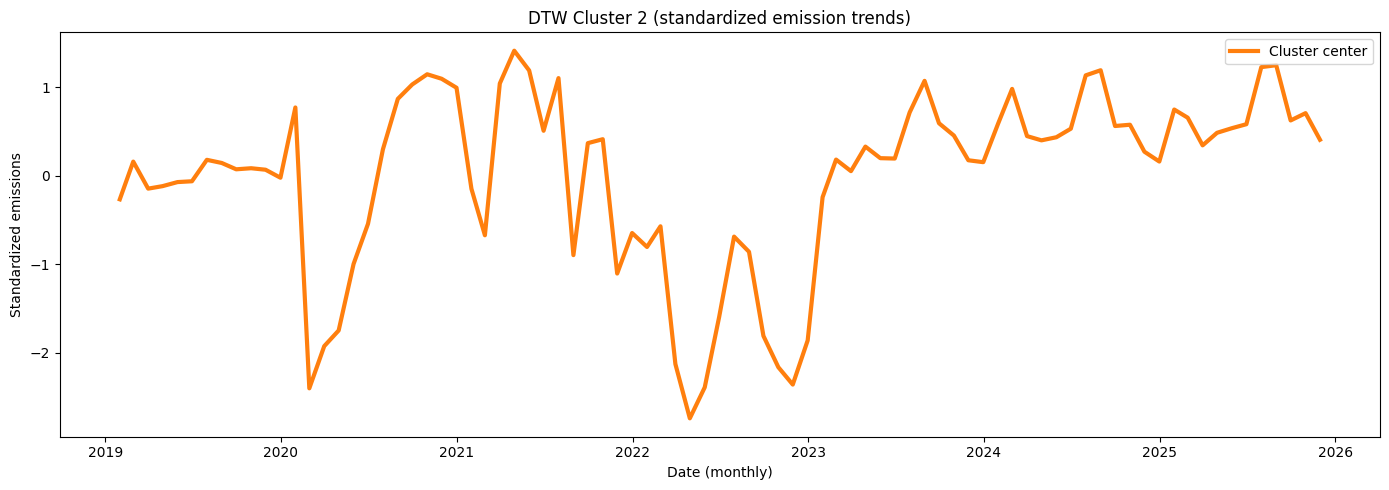

In [454]:
dates = pivot.columns

for c in range(k):
    members = np.where(dtw_labels == c)[0]
    plt.figure(figsize=(14, 5))
    for idx in members:
        plt.plot(dates, X_scaled[idx, :, 0], alpha=0.6, linewidth=1)

    center = dtw_km.cluster_centers_[c, :, 0]
    plt.plot(dates, center, linewidth=3, label="Cluster center")

    plt.title(f"DTW Cluster {c} (standardized emission trends)")
    plt.xlabel("Date (monthly)")
    plt.ylabel("Standardized emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

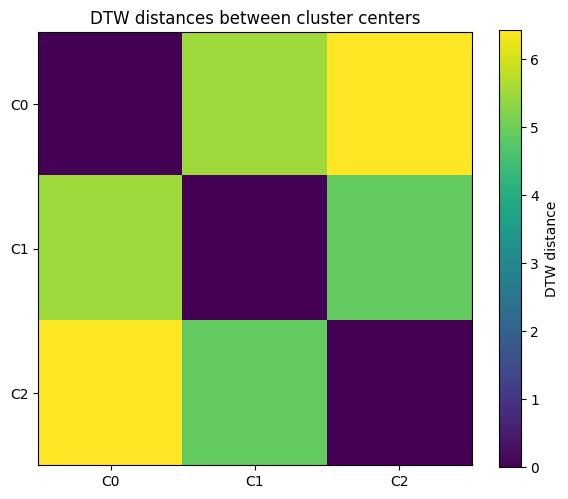

In [455]:
centers = dtw_km.cluster_centers_[:, :, 0]
center_dist = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        center_dist[i, j] = dtw(centers[i], centers[j])

plt.figure(figsize=(6, 5))
plt.imshow(center_dist)
plt.colorbar(label="DTW distance")
plt.xticks(range(k), [f"C{i}" for i in range(k)])
plt.yticks(range(k), [f"C{i}" for i in range(k)])
plt.title("DTW distances between cluster centers")
plt.tight_layout()
plt.show()